PAPER'S CHANNEL INFORMATION (Table 2)
Paper's 33 channels (0-based indexing):
  Channel  0: Fp1
  Channel  1: Fp2
  Channel  2: Pz
  Channel  3: P3
  Channel  4: P4
  Channel  5: F7
  Channel  6: F8
  Channel  7: FC2
  Channel  8: FC3
  Channel  9: FC4
  Channel 10: FT7
  Channel 11: FT8
  Channel 12: Cz
  Channel 13: C3
  Channel 14: C4
  Channel 15: T3
  Channel 16: T4
  Channel 17: CPz
  Channel 18: CP3
  Channel 19: CP4
  Channel 20: TP7
  Channel 21: TP8
  Channel 22: Pz
  Channel 23: P3
  Channel 24: P4
  Channel 25: T5
  Channel 26: T6
  Channel 27: Oz
  Channel 28: O1
  Channel 29: O2
  Channel 30: HEOL
  Channel 31: VEOR
  Channel 32: Marker

Breakdown:
  EEG channels: 30
  EOG channels: 2
  Marker channels: 1
  Total: 33

EVENT MARKER ANALYSIS
Total MI events: 40 (should be 40)
First 5 MI events:
    onset  duration  trial_type  value
1    2001      4000           1      2
4   10001      4000           2      2
7   18001      4000           1      2
10  26001      4000       

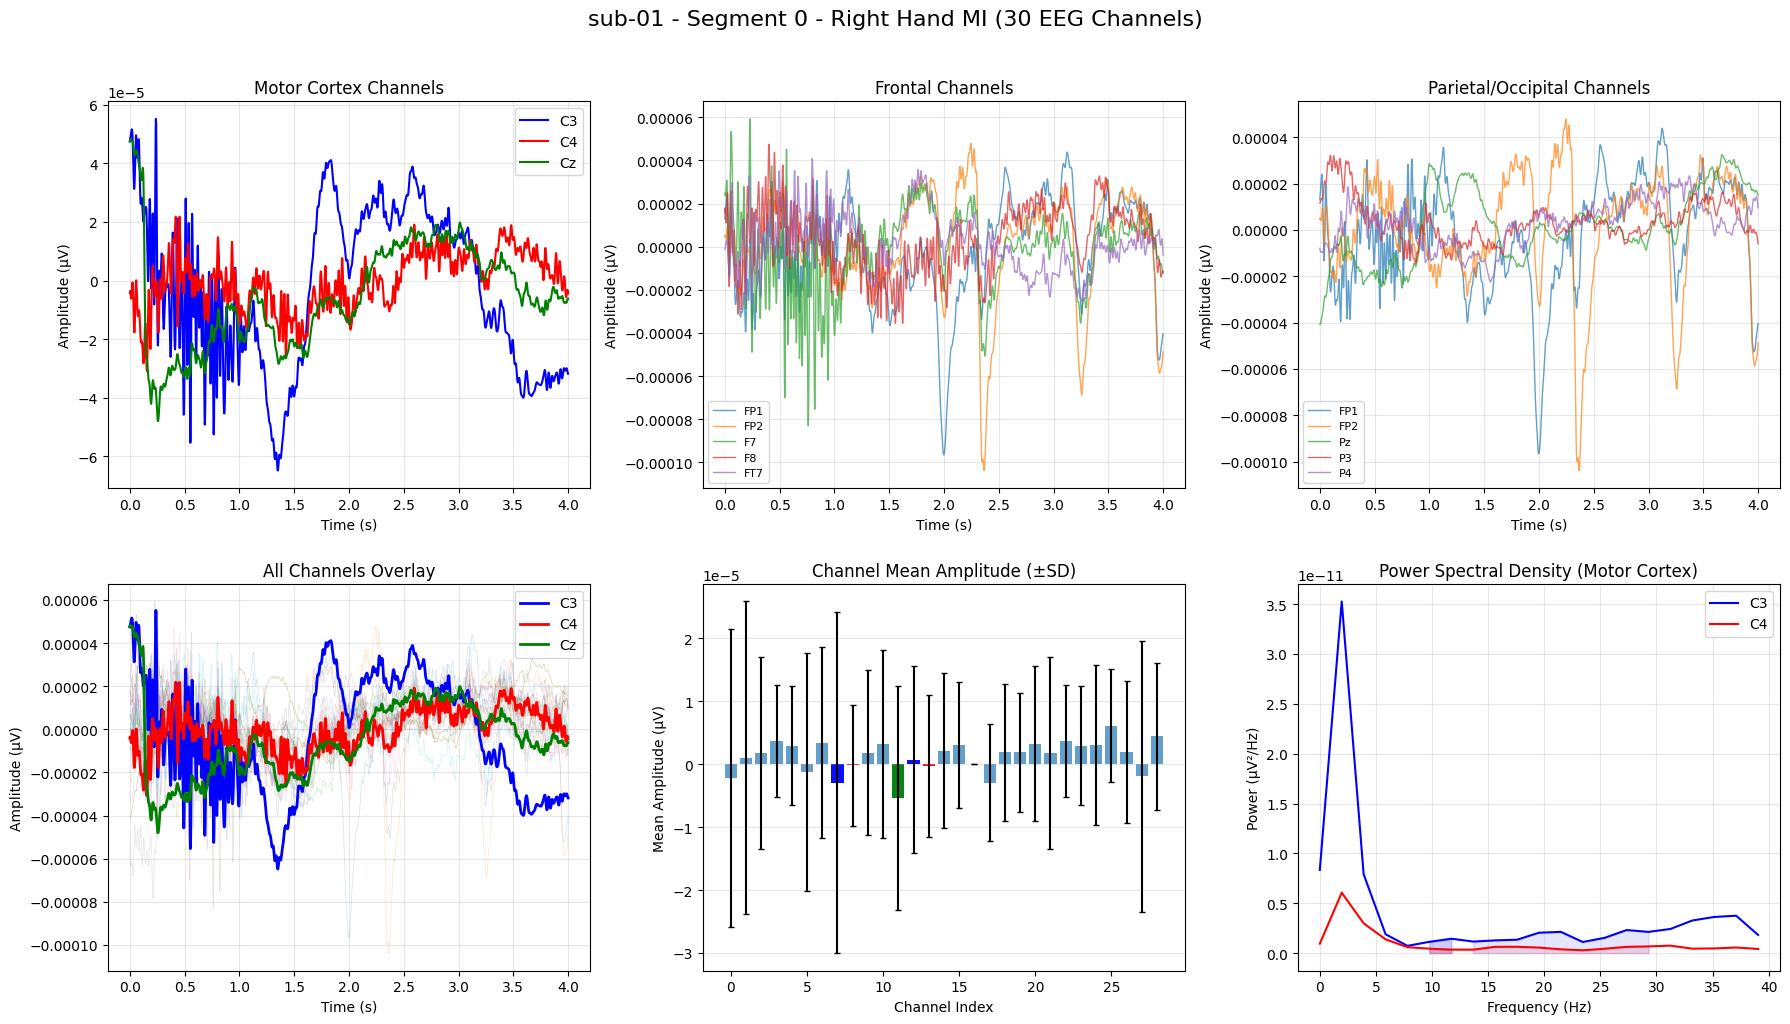


📊 Segment 0 Statistics:
  Subject: sub-01
  Label: 2 (Right hand)
  Shape: (29, 2000)
  C3: -0.00 ± 0.00 μV
  C4: -0.00 ± 0.00 μV
  Cz: -0.00 ± 0.00 μV


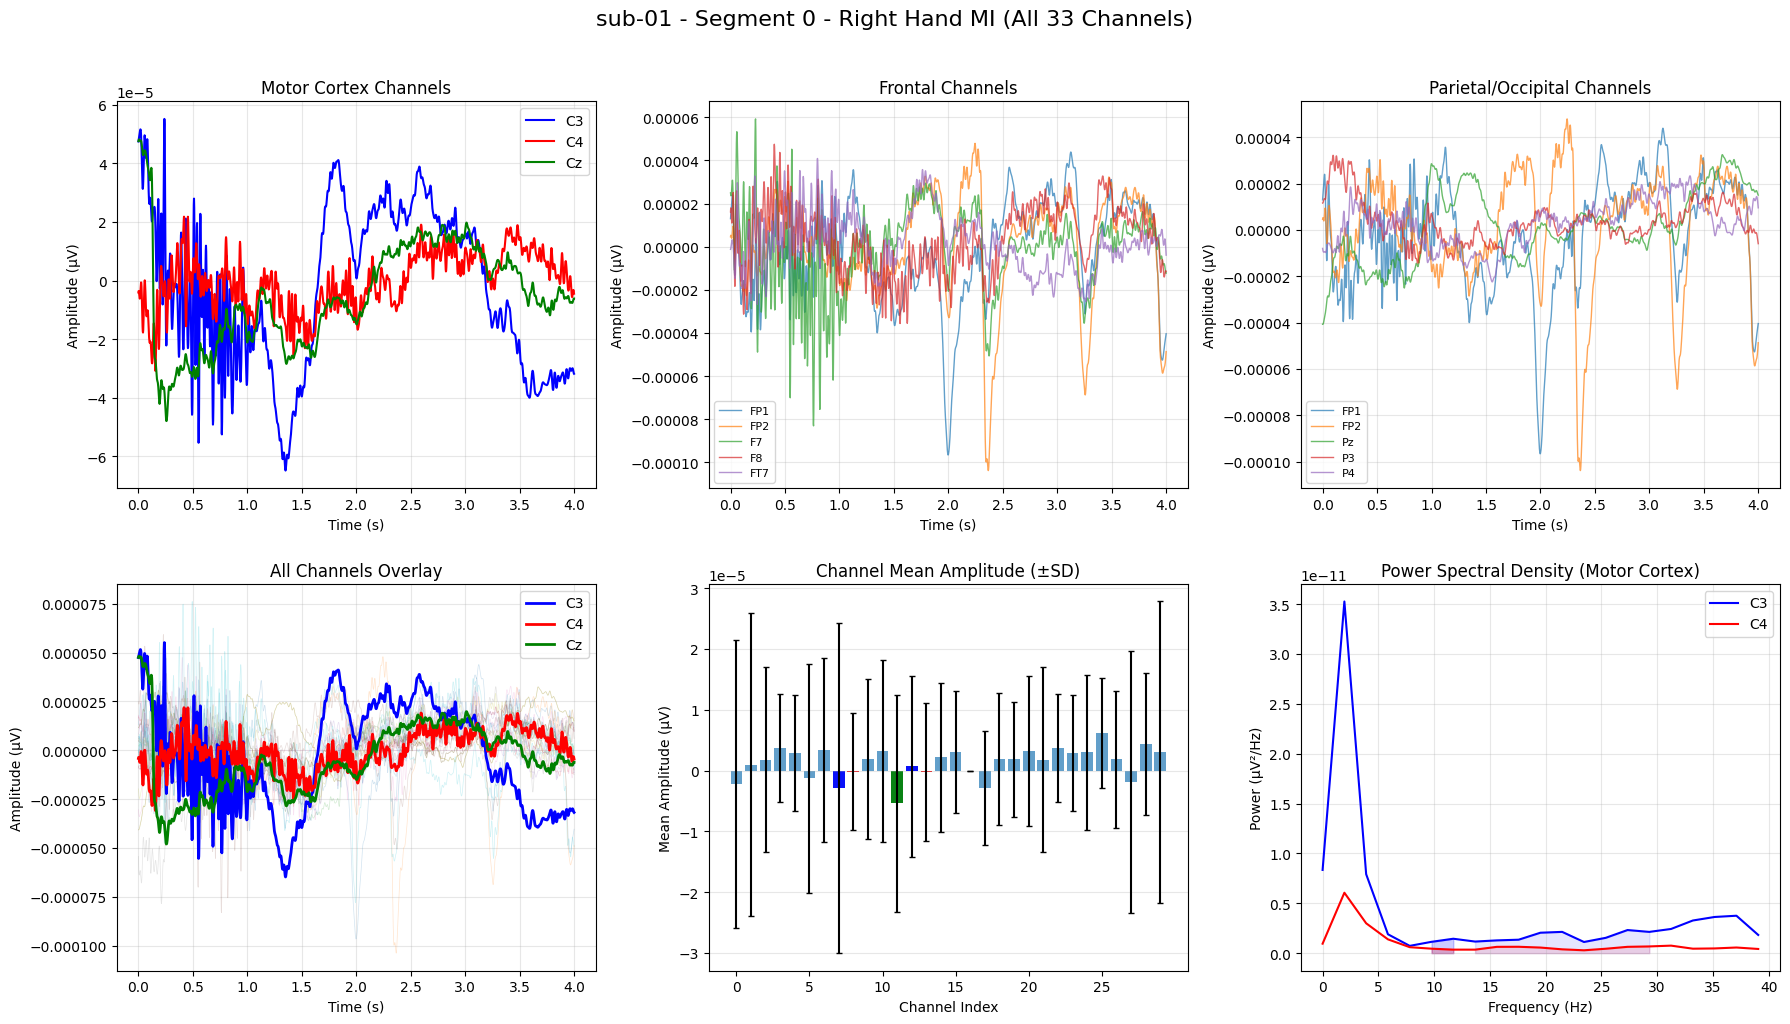


📊 Segment 0 Statistics:
  Subject: sub-01
  Label: 2 (Right hand)
  Shape: (30, 2000)
  C3: -0.00 ± 0.00 μV
  C4: -0.00 ± 0.00 μV
  Cz: -0.00 ± 0.00 μV

READY TO PROCESS ALL SUBJECTS
To process the dataset with 33-channel specification:

# Test with 2 subjects
print("Testing with 2 subjects...")
test_results = process_all_subjects_33channels(base_path, max_subjects=2, save_results=True)

# Visualize
if test_results and 'sub-01' in test_results:
    visualize_33_channels(test_results['sub-01'], segment_idx=0, show_type='eeg')
    visualize_33_channels(test_results['sub-01'], segment_idx=10, show_type='eeg')

# Process all subjects
print("\nProcessing all subjects...")
all_results = process_all_subjects_33channels(base_path, save_results=True)


RUNNING QUICK TEST
Running quick test with 1 subject...

PROCESSING 1 SUBJECTS (33 CHANNELS)

[1/1] Processing sub-01

📊 Processing sub-01 with 33-channel specification...
  Channels in .edf file: 33
  First 10 channel names: ['FP1', 'FP2', 'Fz'

In [1]:
# ============================================
# CORRECTED SOLUTION WITH 33 CHANNELS FROM PAPER
# ============================================
import os
import numpy as np
import pandas as pd
import mne
from mne.io import read_raw_edf
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set base path
base_path = r"D:\impress_project\eeg_signals\data\LRMI-21679035\organized_data_v2"

# ============================================
# STEP 1: Load Paper's Channel Information
# ============================================
print("="*60)
print("PAPER'S CHANNEL INFORMATION (Table 2)")
print("="*60)

# From paper Table 2 (1-based indexing):
paper_channels_1based = {
    1: 'Fp1', 2: 'Fp2', 3: 'Pz', 4: 'P3', 5: 'P4', 6: 'F7', 7: 'F8', 8: 'FC2', 
    9: 'FC3', 10: 'FC4', 11: 'FT7', 12: 'FT8', 13: 'Cz', 14: 'C3', 15: 'C4',
    16: 'T3', 17: 'T4', 18: 'CPz', 19: 'CP3', 20: 'CP4', 21: 'TP7', 22: 'TP8',
    23: 'Pz', 24: 'P3', 25: 'P4', 26: 'T5', 27: 'T6', 28: 'Oz', 29: 'O1',
    30: 'O2', 31: 'HEOL', 32: 'VEOR', 33: 'Marker'  # Assuming HEOL=H-EOG, VEOR=V-EOG
}

# Convert to 0-based indexing for Python
paper_channels = {i-1: name for i, name in paper_channels_1based.items()}

print("Paper's 33 channels (0-based indexing):")
for i in range(33):
    print(f"  Channel {i:2d}: {paper_channels.get(i, 'Unknown')}")

# Separate into EEG, EOG, and Marker
eeg_channels = []
eog_channels = []
marker_channels = []

for idx, name in paper_channels.items():
    if 'HEOL' in name or 'VEOR' in name or 'EOG' in name.upper():
        eog_channels.append((idx, name))
    elif 'MARKER' in name.upper():
        marker_channels.append((idx, name))
    else:
        eeg_channels.append((idx, name))

print(f"\nBreakdown:")
print(f"  EEG channels: {len(eeg_channels)}")
print(f"  EOG channels: {len(eog_channels)}")
print(f"  Marker channels: {len(marker_channels)}")
print(f"  Total: {len(eeg_channels) + len(eog_channels) + len(marker_channels)}")

# ============================================
# STEP 2: Load Event Markers
# ============================================
print("\n" + "="*60)
print("EVENT MARKER ANALYSIS")
print("="*60)

events_path = os.path.join(base_path, "events", "task-motor-imagery_events.tsv")
events_df = pd.read_csv(events_path, sep='\t')

# Filter for MI events (value=2, duration=4000ms)
mi_events = events_df[(events_df['value'] == 2) & (events_df['duration'] == 4000)].copy()
mi_events['onset_seconds'] = mi_events['onset'] / 1000.0
mi_events['duration_seconds'] = mi_events['duration'] / 1000.0

print(f"Total MI events: {len(mi_events)} (should be 40)")
print(f"First 5 MI events:")
print(mi_events[['onset', 'duration', 'trial_type', 'value']].head())

# ============================================
# STEP 3: Correct Channel Extraction for .edf Files
# ============================================
def extract_channels_by_paper_specification(raw):
    """
    Extract channels according to paper's 33-channel specification
    
    Parameters:
    -----------
    raw : mne.io.Raw
        Loaded EEG data
        
    Returns:
    --------
    eeg_data : ndarray
        EEG data (30 channels)
    eog_data : ndarray
        EOG data (2 channels)
    marker_data : ndarray
        Marker data (1 channel)
    channel_names : dict
        Dictionary with channel information
    """
    
    # Get all channel names from the .edf file
    all_ch_names = raw.ch_names
    print(f"  Channels in .edf file: {len(all_ch_names)}")
    print(f"  First 10 channel names: {all_ch_names[:10]}")
    
    # Try to map paper channels to actual .edf channels
    # The .edf file might have different naming conventions
    
    # Common naming variations
    channel_variations = {
        'Fp1': ['FP1', 'Fp1', 'FP1'],
        'Fp2': ['FP2', 'Fp2', 'FP2'],
        'C3': ['C3', 'C3'],
        'C4': ['C4', 'C4'],
        'Cz': ['CZ', 'Cz', 'Cz'],
        'HEOL': ['HEOG', 'EOGH', 'H-EOG', 'HEOL'],
        'VEOR': ['VEOG', 'EOGV', 'V-EOG', 'VEOR'],
        'Marker': ['STIM', 'TRIGGER', 'MARKER', 'EVENT']
    }
    
    # Try to find each paper channel in the .edf file
    found_channels = {}
    
    for paper_idx, paper_name in paper_channels.items():
        found = False
        
        # Try exact match
        if paper_name in all_ch_names:
            found_channels[paper_idx] = paper_name
            found = True
        
        # Try case-insensitive match
        if not found:
            for edf_name in all_ch_names:
                if paper_name.upper() == edf_name.upper():
                    found_channels[paper_idx] = edf_name
                    found = True
                    break
        
        # Try variations
        if not found and paper_name in channel_variations:
            for variation in channel_variations[paper_name]:
                for edf_name in all_ch_names:
                    if variation.upper() == edf_name.upper():
                        found_channels[paper_idx] = edf_name
                        found = True
                        break
                if found:
                    break
    
    print(f"  Channels matched to paper specification: {len(found_channels)}/33")
    
    if len(found_channels) < 30:
        print(f"  ⚠️ Warning: Only found {len(found_channels)} channels matching paper spec")
        print(f"  Using all available channels and mapping by position")
        
        # Fallback: Use first 33 channels and assume they follow paper order
        for i in range(min(33, len(all_ch_names))):
            found_channels[i] = all_ch_names[i]
    
    # Extract data for found channels
    channel_indices = []
    channel_names_ordered = []
    
    for i in range(33):
        if i in found_channels:
            ch_name = found_channels[i]
            if ch_name in all_ch_names:
                channel_indices.append(all_ch_names.index(ch_name))
                channel_names_ordered.append(ch_name)
            else:
                print(f"  Warning: Channel {ch_name} not found in data")
    
    # Extract all data
    if channel_indices:
        all_data, _ = raw[channel_indices, :]
        
        # Separate by type
        eeg_indices = []
        eog_indices = []
        marker_indices = []
        
        for i, (paper_idx, ch_name) in enumerate(found_channels.items()):
            paper_name = paper_channels.get(paper_idx, '')
            
            if 'HEOL' in paper_name or 'VEOR' in paper_name or 'EOG' in paper_name.upper():
                eog_indices.append(i)
            elif 'MARKER' in paper_name.upper():
                marker_indices.append(i)
            else:
                eeg_indices.append(i)
        
        # Extract separated data
        if eeg_indices:
            eeg_data = all_data[eeg_indices, :]
            eeg_ch_names = [channel_names_ordered[i] for i in eeg_indices]
        else:
            eeg_data = all_data[:30, :]  # Assume first 30 are EEG
            eeg_ch_names = channel_names_ordered[:30]
        
        if eog_indices:
            eog_data = all_data[eog_indices, :]
            eog_ch_names = [channel_names_ordered[i] for i in eog_indices]
        else:
            eog_data = None
            eog_ch_names = []
        
        if marker_indices:
            marker_data = all_data[marker_indices, :]
            marker_ch_names = [channel_names_ordered[i] for i in marker_indices]
        else:
            marker_data = None
            marker_ch_names = []
        
        return {
            'eeg': eeg_data,
            'eeg_names': eeg_ch_names,
            'eog': eog_data,
            'eog_names': eog_ch_names,
            'marker': marker_data,
            'marker_names': marker_ch_names,
            'all_data': all_data,
            'all_names': channel_names_ordered
        }
    else:
        # Fallback: extract all channels
        all_data, _ = raw[:, :]
        return {
            'eeg': all_data[:30, :],
            'eeg_names': all_ch_names[:30],
            'eog': all_data[30:32, :] if len(all_ch_names) >= 32 else None,
            'eog_names': all_ch_names[30:32] if len(all_ch_names) >= 32 else [],
            'marker': all_data[32:33, :] if len(all_ch_names) >= 33 else None,
            'marker_names': all_ch_names[32:33] if len(all_ch_names) >= 33 else [],
            'all_data': all_data,
            'all_names': all_ch_names
        }

# ============================================
# STEP 4: Load and Test with .edf File
# ============================================
print("\n" + "="*60)
print("LOADING .edf FILE WITH PAPER'S CHANNEL SPEC")
print("="*60)

# Find .edf files
preprocessed_path = os.path.join(base_path, "paper_preprocessed")
edf_files = [f for f in os.listdir(preprocessed_path) if f.endswith('.edf')]

if edf_files:
    # Load first .edf file
    test_edf = os.path.join(preprocessed_path, edf_files[0])
    subject_id = edf_files[0].split('_')[0]
    
    print(f"Loading: {edf_files[0]}")
    raw = read_raw_edf(test_edf, preload=True, verbose=False)
    
    # Extract channels according to paper specification
    channel_data = extract_channels_by_paper_specification(raw)
    
    print(f"\n✅ Channel extraction complete:")
    print(f"  EEG channels: {len(channel_data['eeg_names'])}")
    print(f"  EOG channels: {len(channel_data['eog_names'])}")
    print(f"  Marker channels: {len(channel_data['marker_names'])}")
    
    print(f"\nEEG channel names:")
    for i, name in enumerate(channel_data['eeg_names'][:15]):  # Show first 15
        print(f"  {i:2d}: {name}")
    if len(channel_data['eeg_names']) > 15:
        print(f"  ... and {len(channel_data['eeg_names']) - 15} more")
    
    # Check for important motor cortex channels
    print(f"\n🔍 Looking for motor cortex channels:")
    for name in channel_data['eeg_names']:
        if 'C3' in name.upper():
            print(f"  Found C3: {name}")
        if 'C4' in name.upper():
            print(f"  Found C4: {name}")
        if 'CZ' in name.upper():
            print(f"  Found Cz: {name}")

# ============================================
# STEP 5: Complete Labeling Function for All 33 Channels
# ============================================
def label_data_with_all_channels(edf_filepath, events_df, subject_id, sampling_rate=500):
    """
    Label data using all 33 channels from paper specification
    
    Parameters:
    -----------
    edf_filepath : str
        Path to .edf file
    events_df : DataFrame
        Event markers
    subject_id : str
        Subject identifier
    sampling_rate : int
        Sampling rate in Hz
        
    Returns:
    --------
    result : dict
        Dictionary with labeled segments
    """
    
    print(f"\n📊 Processing {subject_id} with 33-channel specification...")
    
    # Load .edf file
    raw = read_raw_edf(edf_filepath, preload=True, verbose=False)
    
    # Verify sampling rate
    actual_sfreq = raw.info['sfreq']
    if abs(actual_sfreq - sampling_rate) > 1:
        print(f"  ⚠️ Sampling rate: {actual_sfreq} Hz (expected {sampling_rate} Hz)")
        sampling_rate = actual_sfreq
    
    # Extract all channels
    channel_data = extract_channels_by_paper_specification(raw)
    all_data = channel_data['all_data']  # All 33 channels
    
    print(f"  Total data shape: {all_data.shape}")
    print(f"  Expected: (33, n_samples)")
    
    # Get MI events
    mi_events = events_df[(events_df['value'] == 2) & (events_df['duration'] == 4000)].copy()
    mi_events['onset_seconds'] = mi_events['onset'] / 1000.0
    mi_events['duration_seconds'] = mi_events['duration'] / 1000.0
    
    print(f"  MI events: {len(mi_events)}")
    
    # Extract segments
    segments_all = []  # All 33 channels
    segments_eeg = []  # Only EEG channels (30)
    labels = []
    event_info = []
    
    for idx, event in mi_events.iterrows():
        start_sec = event['onset_seconds']
        duration_sec = event['duration_seconds']
        end_sec = start_sec + duration_sec
        
        # Convert to samples
        start_sample = int(start_sec * sampling_rate)
        end_sample = int(end_sec * sampling_rate)
        
        # Check bounds
        if end_sample <= all_data.shape[1]:
            # Extract from all channels
            segment_all = all_data[:, start_sample:end_sample]
            segments_all.append(segment_all)
            
            # Extract only EEG channels
            segment_eeg = channel_data['eeg'][:, start_sample:end_sample]
            segments_eeg.append(segment_eeg)
            
            # Determine label
            trial_type = event['trial_type']
            # Based on your previous results and common convention:
            # trial_type 1 = right hand (label 2)
            # trial_type 2 = left hand (label 1)
            if trial_type == 1:
                label = 2  # Right hand
                hand = "right"
            else:  # trial_type == 2
                label = 1  # Left hand
                hand = "left"
            
            labels.append(label)
            
            event_info.append({
                'event_idx': idx,
                'onset_sec': start_sec,
                'duration_sec': duration_sec,
                'onset_sample': start_sample,
                'end_sample': end_sample,
                'label': label,
                'hand': hand,
                'trial_type': trial_type
            })
    
    if segments_all:
        # Convert to numpy arrays
        segments_all_array = np.array(segments_all)
        segments_eeg_array = np.array(segments_eeg)
        labels_array = np.array(labels)
        
        print(f"\n✅ Extraction complete:")
        print(f"  Segments (all 33 channels): {segments_all_array.shape}")
        print(f"  Segments (EEG only): {segments_eeg_array.shape}")
        print(f"  Labels: {labels_array.shape}")
        
        # Label distribution
        unique_labels, counts = np.unique(labels_array, return_counts=True)
        print(f"\n🏷️ Label distribution:")
        for label, count in zip(unique_labels, counts):
            hand = "Left" if label == 1 else "Right"
            percentage = count / len(labels_array) * 100
            print(f"  {hand} hand: {count} segments ({percentage:.1f}%)")
        
        return {
            'subject_id': subject_id,
            'segments_all': segments_all_array,  # All 33 channels
            'segments_eeg': segments_eeg_array,  # Only 30 EEG channels
            'labels': labels_array,
            'sampling_rate': sampling_rate,
            'duration_seconds': 4.0,
            'channels_all': channel_data['all_names'],
            'channels_eeg': channel_data['eeg_names'],
            'channels_eog': channel_data['eog_names'],
            'channels_marker': channel_data['marker_names'],
            'event_info': pd.DataFrame(event_info)
        }
    else:
        print("❌ No segments extracted")
        return None

# ============================================
# STEP 6: Test the Complete Labeling
# ============================================
print("\n" + "="*60)
print("TESTING COMPLETE 33-CHANNEL LABELING")
print("="*60)

if edf_files:
    result = label_data_with_all_channels(
        test_edf,
        events_df,
        subject_id,
        sampling_rate=500
    )
    
    if result:
        print(f"\n📈 FINAL RESULTS for {subject_id}:")
        print(f"  All channels shape: {result['segments_all'].shape}")
        print(f"  EEG only shape: {result['segments_eeg'].shape}")
        print(f"  Labels: {result['labels'][:10]}...")
        print(f"  Sampling rate: {result['sampling_rate']} Hz")
        print(f"  EEG channels: {len(result['channels_eeg'])}")
        print(f"  EOG channels: {len(result['channels_eog'])}")
        print(f"  Marker channels: {len(result['channels_marker'])}")

# ============================================
# STEP 7: Visualization for 33 Channels
# ============================================
def visualize_33_channels(result, segment_idx=0, show_type='eeg'):
    """
    Visualize segments with all 33 channels
    
    Parameters:
    -----------
    result : dict
        Labeling result
    segment_idx : int
        Segment index to visualize
    show_type : str
        'eeg' for EEG only, 'all' for all channels
    """
    
    if result is None:
        print("No result to visualize")
        return
    
    if show_type == 'eeg':
        data = result['segments_eeg']
        channels = result['channels_eeg']
        title_suffix = " (30 EEG Channels)"
    else:
        data = result['segments_all']
        channels = result['channels_all']
        title_suffix = " (All 33 Channels)"
    
    if segment_idx >= len(data):
        print(f"Segment {segment_idx} out of bounds")
        return
    
    segment = data[segment_idx]
    label = result['labels'][segment_idx]
    hand = "Left" if label == 1 else "Right"
    
    # Create time axis
    sampling_rate = result['sampling_rate']
    duration = result['duration_seconds']
    time_axis = np.linspace(0, duration, segment.shape[1])
    
    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'{result["subject_id"]} - Segment {segment_idx} - {hand} Hand MI{title_suffix}', 
                 fontsize=16, y=1.02)
    
    # Plot 1: Motor cortex channels (C3, C4, Cz)
    motor_channels = []
    for i, ch_name in enumerate(channels):
        ch_upper = ch_name.upper()
        if 'C3' in ch_upper:
            motor_channels.append((i, 'C3', 'blue'))
        elif 'C4' in ch_upper:
            motor_channels.append((i, 'C4', 'red'))
        elif 'CZ' in ch_upper or 'Cz' in ch_name:
            motor_channels.append((i, 'Cz', 'green'))
    
    for idx, label_name, color in motor_channels[:3]:  # Show up to 3
        axes[0, 0].plot(time_axis, segment[idx, :], color=color, 
                       linewidth=1.5, label=label_name)
    axes[0, 0].set_title('Motor Cortex Channels')
    axes[0, 0].set_xlabel('Time (s)')
    axes[0, 0].set_ylabel('Amplitude (μV)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Frontal channels
    frontal_indices = []
    for i, ch_name in enumerate(channels):
        ch_upper = ch_name.upper()
        if 'FP' in ch_upper or ('F' in ch_upper and 'C' not in ch_upper):
            frontal_indices.append(i)
    
    for idx in frontal_indices[:5]:  # First 5 frontal
        axes[0, 1].plot(time_axis, segment[idx, :], alpha=0.7, 
                       linewidth=1, label=channels[idx])
    axes[0, 1].set_title('Frontal Channels')
    axes[0, 1].set_xlabel('Time (s)')
    axes[0, 1].set_ylabel('Amplitude (μV)')
    axes[0, 1].legend(fontsize=8)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Parietal/Occipital channels
    parietal_indices = []
    for i, ch_name in enumerate(channels):
        ch_upper = ch_name.upper()
        if 'P' in ch_upper or 'O' in ch_upper:
            parietal_indices.append(i)
    
    for idx in parietal_indices[:5]:  # First 5 parietal/occipital
        axes[0, 2].plot(time_axis, segment[idx, :], alpha=0.7, 
                       linewidth=1, label=channels[idx])
    axes[0, 2].set_title('Parietal/Occipital Channels')
    axes[0, 2].set_xlabel('Time (s)')
    axes[0, 2].set_ylabel('Amplitude (μV)')
    axes[0, 2].legend(fontsize=8)
    axes[0, 2].grid(True, alpha=0.3)
    
    # Plot 4: All channels overlay (transparent)
    axes[1, 0].plot(time_axis, segment.T, alpha=0.2, linewidth=0.5)
    # Highlight motor channels
    for idx, label_name, color in motor_channels[:3]:
        axes[1, 0].plot(time_axis, segment[idx, :], color=color, 
                       linewidth=2, label=label_name)
    axes[1, 0].set_title('All Channels Overlay')
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_ylabel('Amplitude (μV)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 5: Channel means
    channel_means = np.mean(segment, axis=1)
    channel_stds = np.std(segment, axis=1)
    
    x_pos = np.arange(len(channels))
    axes[1, 1].bar(x_pos, channel_means, yerr=channel_stds, alpha=0.7, capsize=2)
    axes[1, 1].set_title('Channel Mean Amplitude (±SD)')
    axes[1, 1].set_xlabel('Channel Index')
    axes[1, 1].set_ylabel('Mean Amplitude (μV)')
    axes[1, 1].set_xticks(x_pos[::5])
    axes[1, 1].set_xticklabels([f'{i}' for i in x_pos[::5]])
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # Highlight motor channels
    for idx, _, color in motor_channels:
        axes[1, 1].bar(idx, channel_means[idx], color=color, alpha=0.9)
    
    # Plot 6: Power spectrum for C3 and C4
    axes[1, 2].clear()
    if motor_channels:
        from scipy import signal
        
        for idx, label_name, color in motor_channels[:2]:  # First 2 motor channels
            # Compute PSD
            f, Pxx = signal.welch(segment[idx, :], fs=sampling_rate, nperseg=256)
            
            # Plot 0-40 Hz
            mask = f <= 40
            axes[1, 2].plot(f[mask], Pxx[mask], color=color, linewidth=1.5, label=label_name)
            
            # Highlight alpha (8-13 Hz) and beta (13-30 Hz) bands
            alpha_mask = (f >= 8) & (f <= 13)
            beta_mask = (f >= 13) & (f <= 30)
            
            if np.any(alpha_mask):
                axes[1, 2].fill_between(f[alpha_mask], 0, Pxx[alpha_mask], 
                                       alpha=0.2, color=color)
            if np.any(beta_mask):
                axes[1, 2].fill_between(f[beta_mask], 0, Pxx[beta_mask], 
                                       alpha=0.1, color=color)
        
        axes[1, 2].set_title('Power Spectral Density (Motor Cortex)')
        axes[1, 2].set_xlabel('Frequency (Hz)')
        axes[1, 2].set_ylabel('Power (μV²/Hz)')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
    else:
        axes[1, 2].text(0.5, 0.5, 'No motor cortex channels found', 
                       ha='center', va='center')
        axes[1, 2].set_title('Power Spectral Density')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n📊 Segment {segment_idx} Statistics:")
    print(f"  Subject: {result['subject_id']}")
    print(f"  Label: {label} ({hand} hand)")
    print(f"  Shape: {segment.shape}")
    
    # Find and print motor channel statistics
    for idx, label_name, _ in motor_channels[:3]:
        mean_val = np.mean(segment[idx, :])
        std_val = np.std(segment[idx, :])
        print(f"  {label_name}: {mean_val:.2f} ± {std_val:.2f} μV")

# Test visualization
if 'result' in locals() and result:
    print("\n" + "="*60)
    print("VISUALIZING 33-CHANNEL DATA")
    print("="*60)
    visualize_33_channels(result, segment_idx=0, show_type='eeg')
    visualize_33_channels(result, segment_idx=0, show_type='all')

# ============================================
# STEP 8: Batch Process All Subjects
# ============================================
def process_all_subjects_33channels(base_path, max_subjects=None, save_results=True):
    """
    Process all subjects with 33-channel specification
    
    Parameters:
    -----------
    base_path : str
        Base path to organized_data_v2
    max_subjects : int or None
        Maximum number of subjects to process
    save_results : bool
        Whether to save results
        
    Returns:
    --------
    all_results : dict
        Dictionary with all results
    """
    
    # Load events
    events_path = os.path.join(base_path, "events", "task-motor-imagery_events.tsv")
    events_df = pd.read_csv(events_path, sep='\t')
    
    # Get .edf files
    preprocessed_path = os.path.join(base_path, "paper_preprocessed")
    edf_files = sorted([f for f in os.listdir(preprocessed_path) if f.endswith('.edf')])
    
    if max_subjects:
        edf_files = edf_files[:max_subjects]
    
    print(f"\n" + "="*60)
    print(f"PROCESSING {len(edf_files)} SUBJECTS (33 CHANNELS)")
    print("="*60)
    
    all_results = {}
    
    for i, edf_file in enumerate(edf_files):
        subject_id = edf_file.split('_')[0]
        print(f"\n[{i+1}/{len(edf_files)}] Processing {subject_id}")
        
        try:
            edf_path = os.path.join(preprocessed_path, edf_file)
            result = label_data_with_all_channels(
                edf_path,
                events_df,
                subject_id,
                sampling_rate=500
            )
            
            if result:
                all_results[subject_id] = result
                print(f"  ✅ Extracted {len(result['labels'])} segments")
                
                # Save individual results
                if save_results:
                    save_dir = os.path.join(base_path, "results", "33channel_labeled")
                    os.makedirs(save_dir, exist_ok=True)
                    
                    save_path = os.path.join(save_dir, f"{subject_id}_33ch.npz")
                    np.savez_compressed(
                        save_path,
                        segments_all=result['segments_all'],
                        segments_eeg=result['segments_eeg'],
                        labels=result['labels'],
                        channels_all=result['channels_all'],
                        channels_eeg=result['channels_eeg'],
                        channels_eog=result['channels_eog'],
                        channels_marker=result['channels_marker'],
                        sampling_rate=result['sampling_rate'],
                        subject_id=result['subject_id'],
                        event_info=result['event_info'].to_dict('records')
                    )
                    print(f"  💾 Saved to: {save_path}")
            
        except Exception as e:
            print(f"  ❌ Error processing {subject_id}: {e}")
    
    # Create summary
    if all_results and save_results:
        print(f"\n" + "="*60)
        print("CREATING SUMMARY")
        print("="*60)
        
        # Save combined dataset (EEG only for ML)
        all_segments_eeg = []
        all_labels = []
        all_subject_ids = []
        
        for subject_id, result in all_results.items():
            all_segments_eeg.append(result['segments_eeg'])
            all_labels.append(result['labels'])
            all_subject_ids.extend([subject_id] * len(result['labels']))
        
        all_segments_eeg = np.vstack(all_segments_eeg)
        all_labels = np.concatenate(all_labels)
        
        combined_path = os.path.join(base_path, "results", "33channel_combined_eeg.npz")
        np.savez_compressed(
            combined_path,
            segments_eeg=all_segments_eeg,
            labels=all_labels,
            subject_ids=np.array(all_subject_ids),
            sampling_rate=500,
            n_subjects=len(all_results),
            n_segments=len(all_segments_eeg)
        )
        
        print(f"💾 Combined EEG dataset saved to: {combined_path}")
        print(f"   Shape: {all_segments_eeg.shape}")
        print(f"   Subjects: {len(all_results)}")
        print(f"   Total segments: {len(all_segments_eeg)}")
        
        # Create summary CSV
        summary_data = []
        for subject_id, result in all_results.items():
            labels = result['labels']
            left_count = np.sum(labels == 1)
            right_count = np.sum(labels == 2)
            
            summary_data.append({
                'subject_id': subject_id,
                'total_segments': len(labels),
                'left_hand': left_count,
                'right_hand': right_count,
                'eeg_channels': len(result['channels_eeg']),
                'eog_channels': len(result['channels_eog']),
                'marker_channels': len(result['channels_marker'])
            })
        
        summary_df = pd.DataFrame(summary_data)
        summary_path = os.path.join(base_path, "results", "33channel_summary.csv")
        summary_df.to_csv(summary_path, index=False)
        print(f"📊 Summary saved to: {summary_path}")
    
    return all_results

# ============================================
# STEP 9: Run the Pipeline
# ============================================
print("\n" + "="*60)
print("READY TO PROCESS ALL SUBJECTS")
print("="*60)

print("To process the dataset with 33-channel specification:")
print("""
# Test with 2 subjects
print("Testing with 2 subjects...")
test_results = process_all_subjects_33channels(base_path, max_subjects=2, save_results=True)

# Visualize
if test_results and 'sub-01' in test_results:
    visualize_33_channels(test_results['sub-01'], segment_idx=0, show_type='eeg')
    visualize_33_channels(test_results['sub-01'], segment_idx=10, show_type='eeg')

# Process all subjects
print("\\nProcessing all subjects...")
all_results = process_all_subjects_33channels(base_path, save_results=True)
""")

# ============================================
# STEP 10: Quick Test
# ============================================
print("\n" + "="*60)
print("RUNNING QUICK TEST")
print("="*60)

print("Running quick test with 1 subject...")
test_results = process_all_subjects_33channels(base_path, max_subjects=1, save_results=True)

if test_results:
    print(f"\n✅ Test successful!")
    print(f"   Processed {len(test_results)} subject(s)")
    print(f"   Data saved to: results/33channel_labeled/")


PROCESSING 2 SUBJECTS (33 CHANNELS)

[1/2] Processing sub-01

📊 Processing sub-01 with 33-channel specification...
  Channels in .edf file: 33
  First 10 channel names: ['FP1', 'FP2', 'Fz', 'F3', 'F4', 'F7', 'F8', 'FCz', 'FC3', 'FC4']
  Channels matched to paper specification: 30/33
  Total data shape: (30, 160000)
  Expected: (33, n_samples)
  MI events: 40

✅ Extraction complete:
  Segments (all 33 channels): (40, 30, 2000)
  Segments (EEG only): (40, 29, 2000)
  Labels: (40,)

🏷️ Label distribution:
  Left hand: 20 segments (50.0%)
  Right hand: 20 segments (50.0%)
  ✅ Extracted 40 segments
  💾 Saved to: D:\impress_project\eeg_signals\data\LRMI-21679035\organized_data_v2\results\33channel_labeled\sub-01_33ch.npz

[2/2] Processing sub-02

📊 Processing sub-02 with 33-channel specification...
  Channels in .edf file: 33
  First 10 channel names: ['FP1', 'FP2', 'Fz', 'F3', 'F4', 'F7', 'F8', 'FCz', 'FC3', 'FC4']
  Channels matched to paper specification: 30/33
  Total data shape: (30, 1

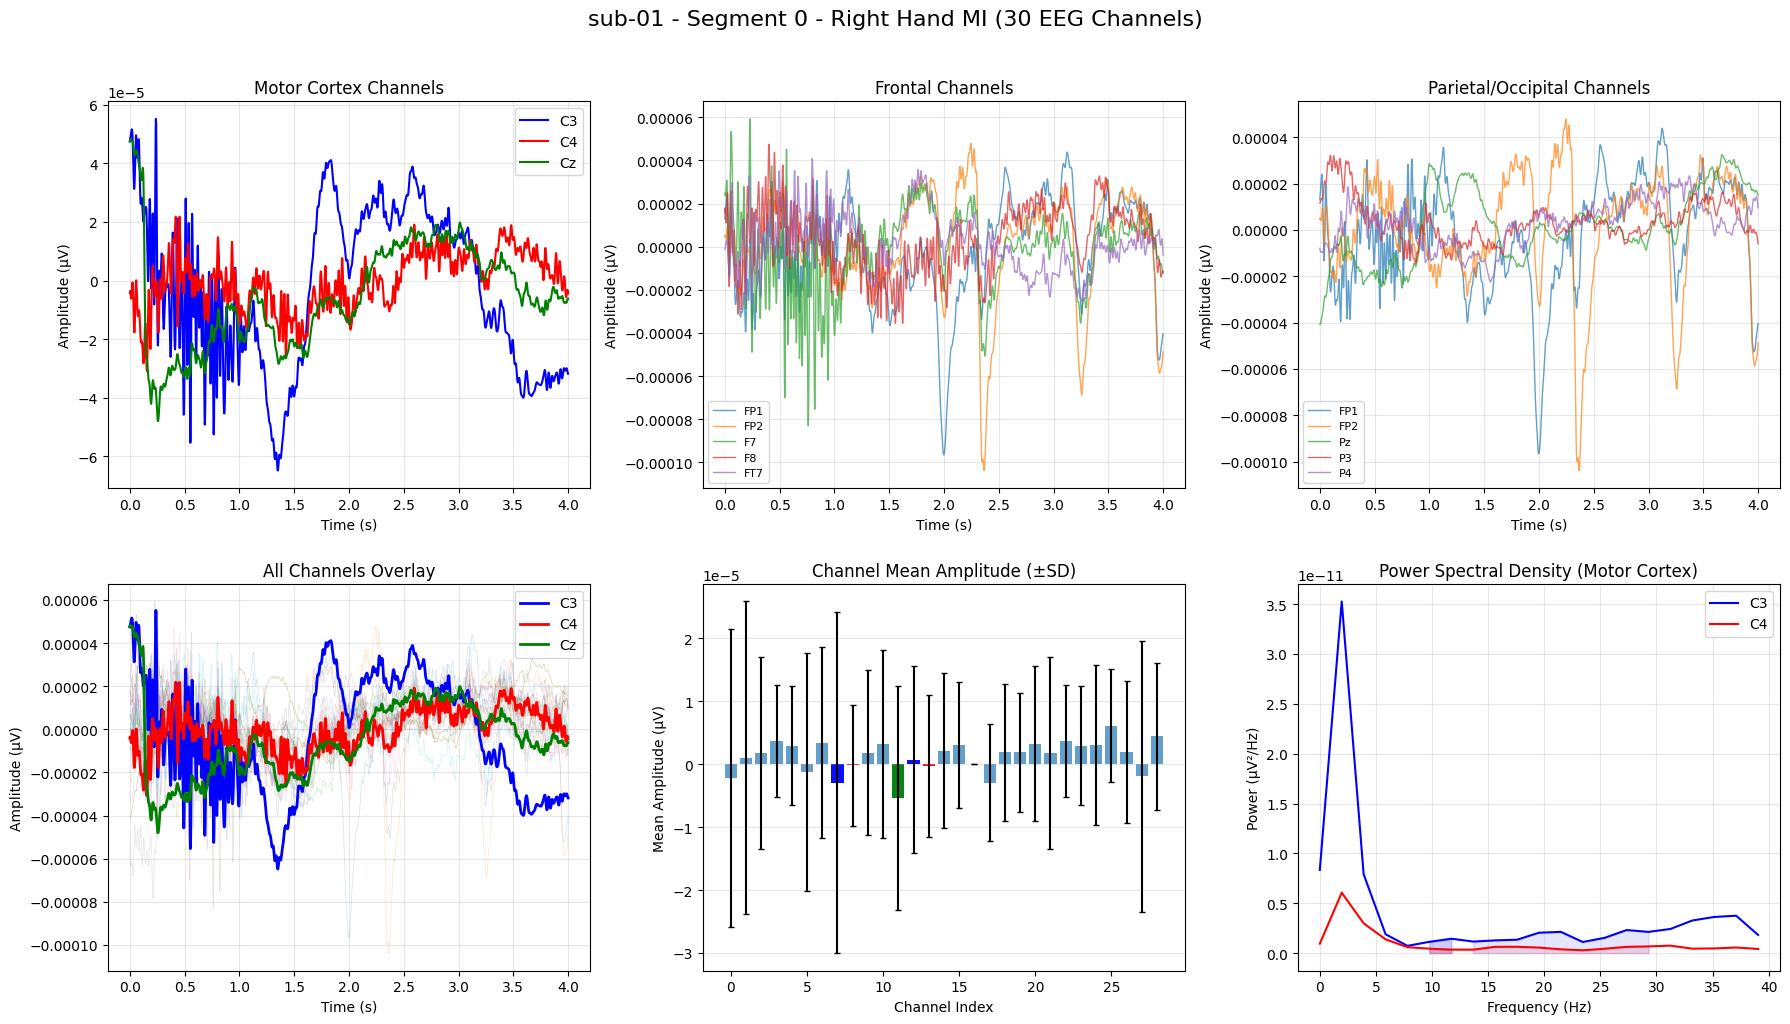


📊 Segment 0 Statistics:
  Subject: sub-01
  Label: 2 (Right hand)
  Shape: (29, 2000)
  C3: -0.00 ± 0.00 μV
  C4: -0.00 ± 0.00 μV
  Cz: -0.00 ± 0.00 μV

PROCESSING 50 SUBJECTS (33 CHANNELS)

[1/50] Processing sub-01

📊 Processing sub-01 with 33-channel specification...
  Channels in .edf file: 33
  First 10 channel names: ['FP1', 'FP2', 'Fz', 'F3', 'F4', 'F7', 'F8', 'FCz', 'FC3', 'FC4']
  Channels matched to paper specification: 30/33
  Total data shape: (30, 160000)
  Expected: (33, n_samples)
  MI events: 40

✅ Extraction complete:
  Segments (all 33 channels): (40, 30, 2000)
  Segments (EEG only): (40, 29, 2000)
  Labels: (40,)

🏷️ Label distribution:
  Left hand: 20 segments (50.0%)
  Right hand: 20 segments (50.0%)
  ✅ Extracted 40 segments
  💾 Saved to: D:\impress_project\eeg_signals\data\LRMI-21679035\organized_data_v2\results\33channel_labeled\sub-01_33ch.npz

[2/50] Processing sub-02

📊 Processing sub-02 with 33-channel specification...
  Channels in .edf file: 33
  First 10 

In [3]:
# Test with 1-2 subjects
test_results = process_all_subjects_33channels(base_path, max_subjects=2, save_results=True)

# Visualize
if test_results and 'sub-01' in test_results:
    visualize_33_channels(test_results['sub-01'], segment_idx=0, show_type='eeg')

# Process all 50 subjects
all_results = process_all_subjects_33channels(base_path, save_results=True)